In [243]:
import os
from pathlib import PosixPath
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import OrderedDict
import shapely
import yaml

tqdm.pandas(ncols=50)

## Data preparation

In [149]:
df = None

for path in [
    'data/trained3_num_cassie4_navigation/*.pkl',
    # 'data/trained3_num_cassie_50kg_1000traj/*.csv',
    # 'data/trained3_num_cassie_50_only_1000traj/*.csv',
]:

    assert len(glob.glob(path)) > 0, f'No files found for {path}'

    for file in glob.glob(path):
        df_ = pd.read_pickle(file)

        if df is None:
            df = df_
        else:
            # Merge rows
            df = pd.concat([df, df_], ignore_index=True)


def extend_columns(x):
    run_args = eval(x['run_args'])

    res = dict(
        # command_x=run_args['command']['x'],
        # command_y=run_args['command']['y'],
        # command_t=run_args['command']['t'],
        # command_h=run_args['command']['h'],
        terrain=run_args['env']['terrain'],
        force=run_args['env']['force'],
        policy=run_args['env']['policy'],
    )

    total_power = 0
    for i, power in enumerate(x['power']):
        res[f'power_{i}'] = power
        total_power += power

    res['power'] = total_power

    joint_forces = []
    for i, joint_force in enumerate(x['joint_forces']):
        res[f'joint_forces_{i}'] = joint_force
        joint_forces.append(joint_force)

    res['joint_forces'] = np.mean(joint_forces)

    res['perturbation_force_start'], res['perturbation_force_end'] = x['perturbation_force_bound']

    res['perturbation_force_window'] = res['perturbation_force_end'] - res['perturbation_force_start']

    total_height_diff = 0
    for i, height_diff in enumerate(x['height_diff']):
        res[f'height_diff_{i}'] = height_diff
        total_height_diff += height_diff

    res['height_diff'] = total_height_diff

    return res


df = pd.concat([df.progress_apply(lambda x: pd.Series(extend_columns(x)), axis=1), df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

df.columns.duplicated().any()

100%|██████████████| 1/1 [00:00<00:00, 718.45it/s]


False

In [150]:
robot_positions = np.array(df['robot_positions'][0])
poi_positions = np.array(df['poi_positions'][0])

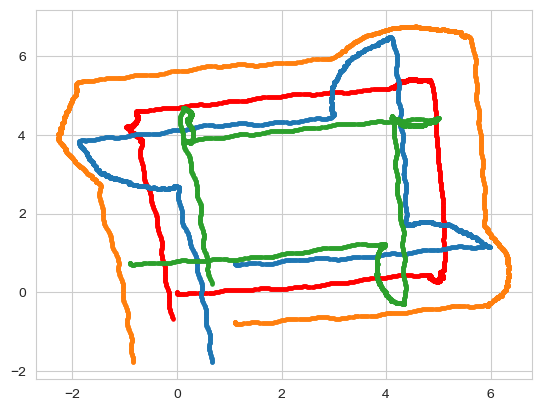

In [152]:

plt.scatter(poi_positions[:, 0], poi_positions[:, 1], c='r', s=5)
plt.scatter(robot_positions[:, 0, 0], robot_positions[:, 0, 1], s=5)
plt.scatter(robot_positions[:, 1, 0], robot_positions[:, 1, 1], s=5)
plt.scatter(robot_positions[:, 2, 0], robot_positions[:, 2, 1], s=5)

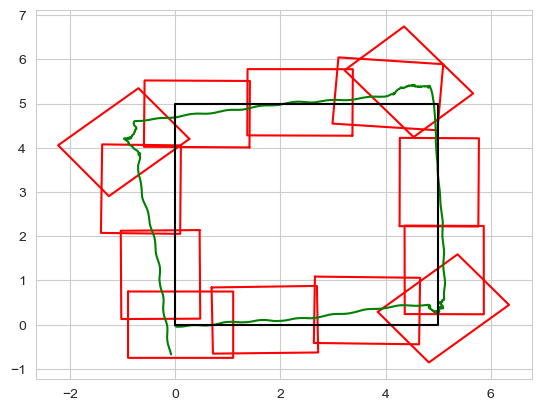

In [255]:
idx = np.arange(0, len(poi_positions), 50)

seconds = list(range(0, 5, 2)) + list(range(18, 22, 2)) + list(range(34, 39, 2)) + list(range(52, 56, 2)) + [11, 28, 45]

idx = idx[seconds]
for i in range(len(idx)):
    plt.plot(robot_positions[idx[i], [2, 0, 1, 3, 2], 0], robot_positions[idx[i], [2, 0, 1, 3, 2], 1], 'r')
    # plt.scatter(poi_positions[i, 0], poi_positions[i, 1], c='g', s=5)
plt.plot(poi_positions[:, 0], poi_positions[:, 1], 'g')

# make square
plt.plot([0, 0, 5, 5, 0], [0, 5, 5, 0, 0], 'k')

In [247]:
with open('configs/trained3_num_cassie4_navigation.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [251]:
config['benchmarks'][0]['command_schedule']

[{'x': 1, 'y': 0, 't': 0, 'h': 0.75, 'duration': 5},
 {'x': 0, 'y': 0, 't': 7.5, 'h': 0.75, 'duration': 12},
 {'x': 1, 'y': 0, 't': 0, 'h': 0.75, 'duration': 5},
 {'x': 0, 'y': 0, 't': 7.5, 'h': 0.75, 'duration': 12},
 {'x': 1, 'y': 0, 't': 0, 'h': 0.75, 'duration': 5},
 {'x': 0, 'y': 0, 't': 7.5, 'h': 0.75, 'duration': 12},
 {'x': 1, 'y': 0, 't': 0, 'h': 0.75, 'duration': 5}]

In [ ]:
poi_position: [4.5170659  0.00857478 1.06688007]
base_positions: [[4.49953532 0.01095796 0.73674828]]
# single cassie

In [ ]:
poi_position: [5.53133291 0.10837933 1.07048537]
base_positions: [[6.27036058 0.12034937 0.76098597]
                 [4.76992332 0.08499185 0.71919198]]
# two cassie

In [ ]:
poi_position: [5.16812585 - 0.98952992  1.05565854]
base_positions: [[6.10515747 - 0.93098502  0.76532727]
                 [5.14617574  0.17278729  0.75468315]
[5.10836016 - 2.18084741
0.75088684]] [0.99047307  0.001526 - 0.00600805 - 0.137567]
# three casse

In [ ]:
poi_position: [4.41032852 3.92838891 1.06312424]
base_positions: [[5.54767798 4.15123689 0.76581603]
                 [4.31768287 4.44911797 0.76037086]
[3.75110129
2.84173061
0.76046202]] [0.93803194 - 0.00224169 - 0.0017893   0.34653693]

# three case longer

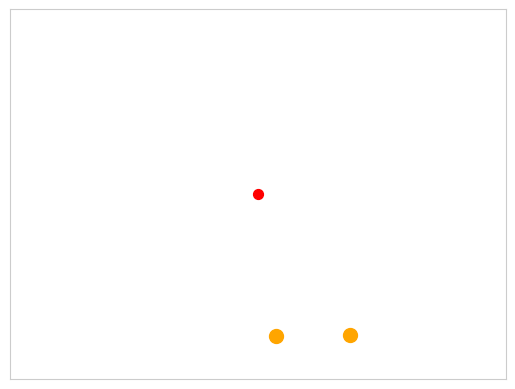

In [283]:
poi_position = np.array([4.41032852, 3.92838891, 1.06312424])
base_position = np.array([[6.27036058, 0.12034937, 0.76098597],
                          [4.76992332, 0.08499185, 0.71919198]])

base_position = base_position - poi_position
poi_position = poi_position - poi_position

plt.scatter(base_position[0, 0], base_position[0, 1], c='orange', s=100)
plt.scatter(base_position[1, 0], base_position[1, 1], c='orange', s=100)
# plt.scatter(base_position[2, 0], base_position[2, 1], c='orange', s=100)
plt.scatter(poi_position[0], poi_position[1], c='r', s=50)
plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(-5, 5)
plt.xlim(-5, 5)

plt.savefig('one_cassie.png', dpi=300)